In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from data_loader import get_loader
from models_singleattn import VqaModel, SANModel
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
input_dir = './datasets'
max_qst_length = 30
max_num_ans = 10
batch_size = 256
num_workers = 8

data_loader = get_loader(
        input_dir=input_dir,
        input_vqa_train='train.npy',
        input_vqa_valid='valid.npy',
        max_qst_length=max_qst_length,
        max_num_ans=max_num_ans,
        batch_size=batch_size,
        num_workers=num_workers)


/home2/chiragp/miniconda3/envs/env2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
qst_vocab_size = data_loader['train'].dataset.qst_vocab.vocab_size
ans_vocab_size = data_loader['train'].dataset.ans_vocab.vocab_size
ans_unk_idx = data_loader['train'].dataset.ans_vocab.unk2idx
print(qst_vocab_size, ans_vocab_size, ans_unk_idx)

embed_size = 1024
word_embed_size = 300
num_layers = 2
hidden_size = 512

model = SANModel(
    embed_size=embed_size,
    qst_vocab_size=qst_vocab_size,
    ans_vocab_size=ans_vocab_size,
    word_embed_size=word_embed_size,
    num_layers=num_layers,
    hidden_size=hidden_size).to(device)

model.load_state_dict(torch.load('models/san_2stack-best_model.ckpt')['state_dict'])
model.eval()


17856 1000 0


SANModel(
  (img_encoder): ImgAttentionEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [5]:
model.attn_features
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook
# model.fc1.register_forward_hook(get_activation('feat_layer'))

[]

In [6]:
vqa_features = {'vqa_idx':[], 'features_fc1': None}
for batch_idx, batch_sample in enumerate(tqdm(data_loader['train'])):
# for batch_idx, batch_sample in enumerate(tqdm(data_loader['valid'])):
    image_index = batch_sample['index']
    
    image = batch_sample['image'].to(device)
    question = batch_sample['question'].to(device)
    label = batch_sample['answer_label'].to(device)
    multi_choice = batch_sample['answer_multi_choice']  # not tensor, list.

    output = model(image, question)      # [batch_size, ans_vocab_size=1000]
    _, pred_exp1 = torch.max(output, 1)  # [batch_size]
    _, pred_exp2 = torch.max(output, 1)  # [batch_size]
    
    break
#     feat_out = activation['feat_layer']
    
#     vqa_features['vqa_idx'] += image_index.tolist()
#     if(vqa_features['features_fc1'] is None):
#         vqa_features['features_fc1'] = feat_out.cpu().numpy()
#     else:
#         vqa_features['features_fc1'] = np.concatenate((vqa_features['features_fc1'], feat_out.cpu().numpy()))


  0%|                                                                                                                                                                               | 0/79 [00:11<?, ?it/s]


In [ ]:
vqa_features = {'vqa_idx':[], 'features_fc1': None}
for batch_idx, batch_sample in enumerate(tqdm(data_loader['train'])):
# for batch_idx, batch_sample in enumerate(tqdm(data_loader['valid'])):
    image_index = batch_sample['index']
    
    image = batch_sample['image'].to(device)
    question = batch_sample['question'].to(device)
    label = batch_sample['answer_label'].to(device)
    multi_choice = batch_sample['answer_multi_choice']  # not tensor, list.

    output = model(image, question)      # [batch_size, ans_vocab_size=1000]
    _, pred_exp1 = torch.max(output, 1)  # [batch_size]
    _, pred_exp2 = torch.max(output, 1)  # [batch_size]
    
    break

In [17]:
import numpy as np
vqa = np.load('datasets/train.npy', allow_pickle=True)
vqa_neighbors= np.load('train_neighbor_matrix_small.npy', allow_pickle=True)
print(vqa_neighbors.shape, vqa.shape)

(443757, 300) (443757,)


In [30]:
from PIL import Image

batch_idx = 10
idx = batch_sample['index'][batch_idx].detach().numpy()

image = vqa[idx]['image_path']
image = Image.open(image).convert('RGB')
print(vqa[idx]['question_str'])
print(vqa[idx]['valid_answers'])

# near_idx = np.random.randint(1,49,1)[0]
# s_image = vqa[vqa_neighbors[idx, near_idx]]['image_path']
# s_image = Image.open(s_image).convert('RGB')

# #far_idx = np.random.randint(1000,1200,1)[0]
# far_idx = np.random.randint(101,249,1)[0]
# o_image = vqa[vqa_neighbors[idx, far_idx]]['image_path']
# o_image = Image.open(o_image).convert('RGB')

What is the man holding in his hand?
['motorcycle', 'motorcycle', 'nothing']


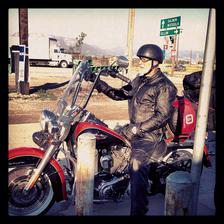

In [31]:
image

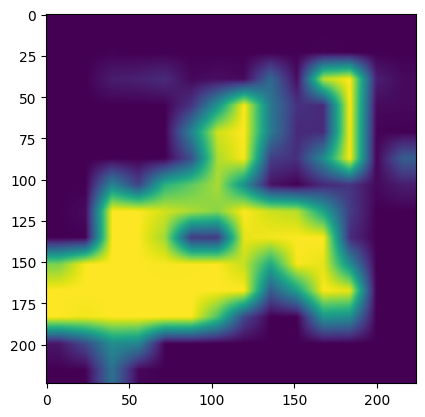

In [32]:
from matplotlib import pyplot as plt
import cv2
attn_map_1 = model.attn_features[0][batch_idx, :, 0].reshape(14, 14)
attn_map_1 = cv2.resize(attn_map_1,(224,224))
plt.imshow(attn_map_1)

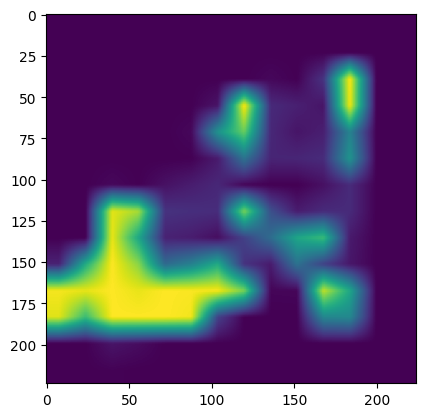

In [33]:
attn_map_2 = model.attn_features[1][batch_idx, :, 0].reshape(14, 14)
attn_map_2 = cv2.resize(attn_map_2,(224,224))
plt.imshow(attn_map_2)